In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [2]:
from pathlib import Path
from fastai import *
from fastai.vision import *
import torch
from fastai.callbacks.hooks import *
from tqdm import tqdm_notebook

import seaborn as sns
import matplotlib.pyplot as plt
import os
import cv2
import glob

In [3]:
train=pd.read_csv('/kaggle/input/spot-the-mask/train_labels.csv')
s=pd.read_csv('/kaggle/input/spot-the-mask/sample_sub.csv')

In [4]:
train

,image,target
0,tfymlmdkpzkqdjhdxyhnoeuqszxphw.jpg,0
1,rxgismgsvmaayzjarbfjaljhqmpbrt.jpg,1
2,uuzshfrhkgrkolhwdvliqauzulurnz.jpg,0
3,mjspxsagzusaznvnyxgamtrlqkqklp.jpg,0
4,rlbmuajgezfiddjzlyeoupxpqubkpt.jpg,1
...,...,...
1303,hxjwafskxmlfaotwaklzuwuccsbxfu.jpg,0
1304,oyodauphffgmzmvqlykcfvmyxartok.jpg,1
1305,uppvtemhkneqggtbfubeccqjvyefiw.png,1
1306,mzjjvzkzvqmyukzsegtoktaslejcdz.jpg,0


In [5]:
s.rename(columns={'+ACI-image+ACI-':'image','+ACI-target+ACI-':'target'},inplace=True)
s


,image,target
0,+ACI-aadawlxbmapqrblgxyzarhjasgiobu.png+ACI-,0
1,+ACI-abpxvdfyhaaohzcrngcucmhffwizxs.jpg+ACI-,0
2,+ACI-aclkjfvackiieiznzfcwienplielrj.jpg+ACI-,0
3,+ACI-aelkivmayxgsdjosiibfgmkvfrjvjk.jpg+ACI-,0
4,+ACI-aelzzshpfxerelefnkatpczktuxjln.jpg+ACI-,0
...,...,...
504,+ACI-zpfhbgixcctxylnihhrepjgcmjksvf.jpg+ACI-,0
505,+ACI-zuignwckjykxefmpubjpjefvhghaoi.jpg+ACI-,0
506,+ACI-zuxvwdblfwjpibjexgfglpyreqslhs.jpg+ACI-,0
507,+ACI-zvyajojutzgqumdjfxxkpiuuxeefyy.jpg+ACI-,0


In [6]:
s['image']=s['image'].apply(lambda x: x[5:-5])

In [7]:
# data_folder = Path("../input/hackerearth-dl-challengeautotag-images-of-gala/dataset")
data_path = "/kaggle/input/spot-the-mask/images"
# path = os.path.join(data_path , "*jpg")
# path

In [8]:
train['target'].value_counts()

0    664
1    644
Name: target, dtype: int64

In [9]:
##transformations to be done to images

tfms = get_transforms(do_flip=True,flip_vert=False 
                      ,max_rotate=12.0, max_zoom=1.6, max_lighting=0.5, max_warp=0.1, p_affine=0.9,
                      p_lighting=0.55
                     )
#, xtra_tfms=zoom_crop(scale=(0.9,1.8), do_rand=True, p=0.8))

## create databunch of test set to be passed
test_img = ImageList.from_df(s, path=data_path, folder='')
test_img

ImageList (509 items)
Image (3, 499, 333),Image (3, 236, 417),Image (3, 900, 1200),Image (3, 168, 299),Image (3, 750, 750)
Path: /kaggle/input/spot-the-mask/images

In [10]:
np.random.seed(145)
## create source of train image databunch
src = (ImageList.from_df(train, path=data_path, folder='')
       .split_by_rand_pct(0.10)
       #.split_none()
       .label_from_df()
       .add_test(test_img))

src

LabelLists;

Train: LabelList (1178 items)
x: ImageList
Image (3, 411, 600),Image (3, 531, 800),Image (3, 166, 166),Image (3, 239, 211),Image (3, 1000, 1500)
y: CategoryList
0,1,0,0,1
Path: /kaggle/input/spot-the-mask/images;

Valid: LabelList (130 items)
x: ImageList
Image (3, 1200, 1800),Image (3, 900, 653),Image (3, 417, 626),Image (3, 194, 259),Image (3, 425, 480)
y: CategoryList
0,0,1,1,0
Path: /kaggle/input/spot-the-mask/images;

Test: LabelList (509 items)
x: ImageList
Image (3, 499, 333),Image (3, 236, 417),Image (3, 900, 1200),Image (3, 168, 299),Image (3, 750, 750)
y: EmptyLabelList
,,,,
Path: /kaggle/input/spot-the-mask/images

In [11]:
data = (src.transform(tfms, size=299,padding_mode='reflection',resize_method=ResizeMethod.SQUISH)
        .databunch(path='.', bs=32, device= torch.device('cuda:0')).normalize(imagenet_stats))

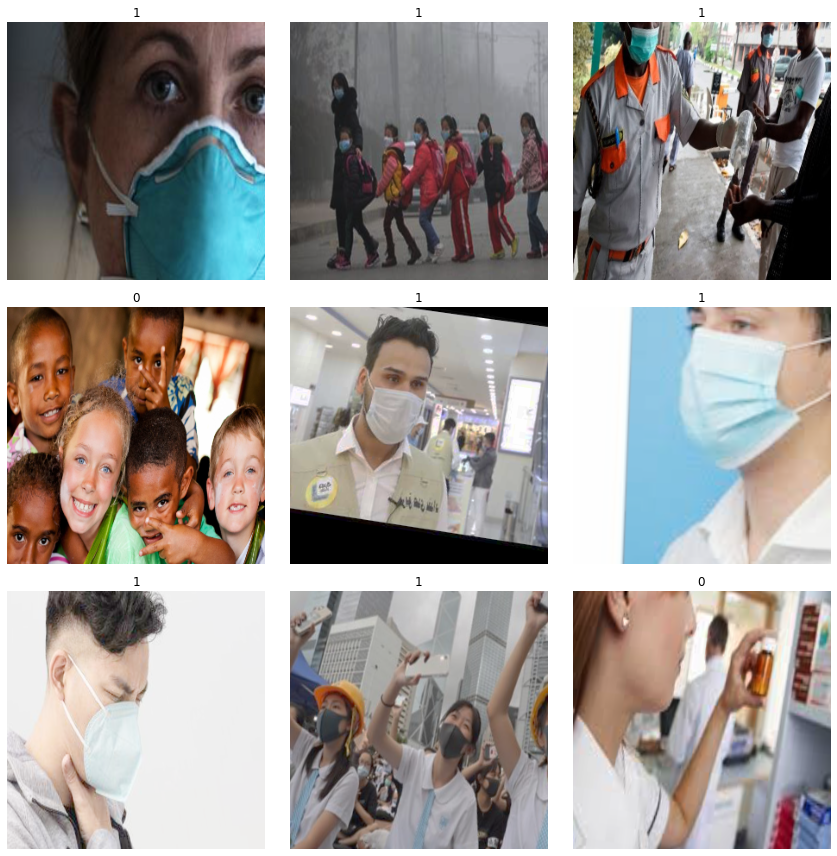

In [12]:
data.show_batch(rows=3, figsize=(12,12))

In [13]:
print(data.classes)

[0, 1]


In [14]:
from fastai.metrics import error_rate # 1 - accuracy
np.random.seed(42)
learn = cnn_learner(data=data, base_arch=models.resnet101, metrics=[error_rate, accuracy],
                    callback_fns=ShowGraph)

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/checkpoints/resnet101-5d3b4d8f.pth


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.98E-04
Min loss divided by 10: 2.75E-03


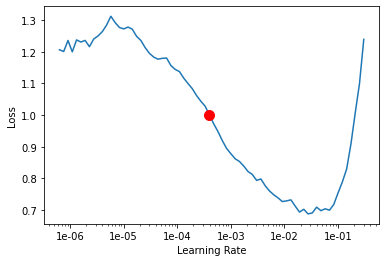

In [15]:
#lets find the correct learning rate to be used from lr finder
np.random.seed(42)
learn.freeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.449332,0.420408,0.076923,0.923077,00:39
1,0.421461,2.665411,0.253846,0.746154,00:36
2,0.367433,0.386711,0.146154,0.853846,00:38
3,0.288882,0.048565,0.015385,0.984615,00:38
4,0.185932,0.089786,0.038462,0.961538,00:36
5,0.119984,0.030071,0.015385,0.984615,00:38
6,0.085942,0.029356,0.015385,0.984615,00:36


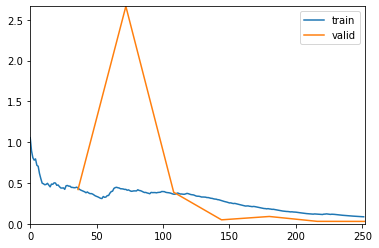

In [16]:
# lr = 5.79E-04
np.random.seed(42)
#learn.fit_one_cycle(10, slice(lr))
learn.fit_one_cycle(7, slice(3.0E-03,3.0E-02), wd=0.25)
learn.save('spotmask-stage-1')

In [17]:
#lets plot the lr finder record
# np.random.seed(42)
# learn.unfreeze()
# learn.lr_find()

# learn.recorder.plot(suggestion=True)

In [18]:
# np.random.seed(42)
# learn.fit_one_cycle(5,slice(6.31E-07),wd=0.25)
# learn.save('spotmask-stage-2')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 1.91E-07


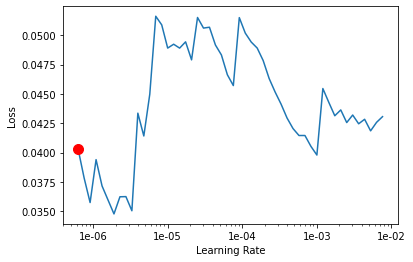

In [19]:
learn.freeze_to(-1)
learn.lr_find()

learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.036509,0.027761,0.015385,0.984615,00:36
1,0.046365,0.031950,0.015385,0.984615,00:38
2,0.052267,0.029064,0.015385,0.984615,00:37
3,0.052362,0.031626,0.015385,0.984615,00:36
4,0.052436,0.035518,0.015385,0.984615,00:37


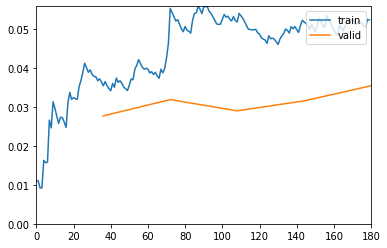

In [20]:
learn.fit_one_cycle(5,slice(6.31E-07,1.0E-06),wd=0.1)
learn.save('spotmask-stage-3')

# learn.unfreeze()
# learn.lr_find()

# learn.recorder.plot(suggestion=True)

In [21]:
# learn.freeze_to(-2)
# learn.lr_find()

# learn.recorder.plot(suggestion=True)

In [22]:
# learn.fit_one_cycle(3,slice(7.59E-07),wd=0.25)
# learn.save('spotmask-stage-4')

In [23]:
# learn.freeze_to(-1)
# learn.lr_find()

# learn.recorder.plot(suggestion=True)

In [24]:
# learn.fit_one_cycle(7,slice(7.59E-07),wd=0.25)
# learn.save('spotmask-stage-4')

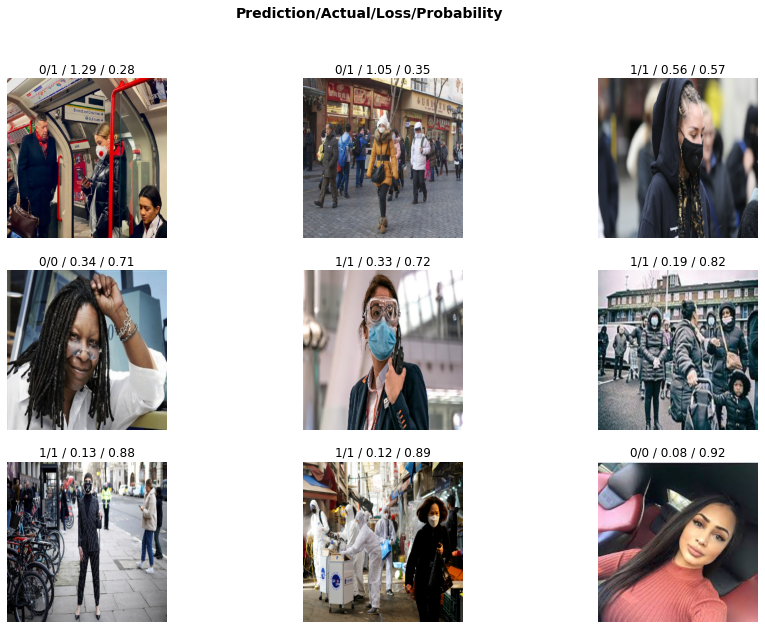

In [25]:
#lets see the most mis-classified images (on validation set)
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(9, figsize=(15,10))

In [26]:
##learn.TTA improves score further. lets see for the validation set
pred_val,y = learn.TTA(ds_type=DatasetType.Valid)
len(pred_val)

130

In [27]:
# np.array(pred_val)[:,-1]

In [28]:
# [pred_val[i] for i in range(len(pred_val))]
y

tensor([0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
        0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0,
        0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1,
        0, 1, 0, 0, 0, 1, 1, 0, 0, 1])

In [29]:
def logloss(true_label, predicted, eps=1e-15):
    p = np.clip(predicted, eps, 1 - eps)
    if true_label == 1:
        return -log(p)
    else:
        return -log(1 - p)

In [30]:
np.argmax(pred_val,1)

tensor([0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
        0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0,
        0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1,
        0, 1, 0, 0, 0, 1, 1, 0, 0, 1])

In [31]:
from sklearn.metrics import f1_score, accuracy_score,log_loss
# valid_preds = [np.argmax(pred_val[i]) for i in range(len(pred_val))]
# valid_preds = np.array(valid_preds)
# valid_preds = np.array(pred_val)[:,-1]
valid_preds = np.argmax(pred_val,1)
# y = np.array(y+1)
log_loss(valid_preds,y)

9.992007221626415e-16

In [32]:
valid_preds

tensor([0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
        0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0,
        0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1,
        0, 1, 0, 0, 0, 1, 1, 0, 0, 1])

In [33]:
preds,_ = learn.TTA(ds_type=DatasetType.Test)
#preds,_ = learn.get_preds(ds_type = DatasetType.Test)
labelled_preds = np.array(preds)[:,-1]

labelled_preds

array([0.807182, 0.245225, 0.996652, 0.990262, ..., 0.015903, 0.074121, 0.960068, 0.5189  ], dtype=float32)

In [34]:
labelled_preds

array([0.807182, 0.245225, 0.996652, 0.990262, ..., 0.015903, 0.074121, 0.960068, 0.5189  ], dtype=float32)

In [35]:
df = pd.DataFrame({'image':s['image'], 'target':labelled_preds})
df

,image,target
0,aadawlxbmapqrblgxyzarhjasgiobu.png,0.807182
1,abpxvdfyhaaohzcrngcucmhffwizxs.jpg,0.245225
2,aclkjfvackiieiznzfcwienplielrj.jpg,0.996652
3,aelkivmayxgsdjosiibfgmkvfrjvjk.jpg,0.990262
4,aelzzshpfxerelefnkatpczktuxjln.jpg,0.001369
...,...,...
504,zpfhbgixcctxylnihhrepjgcmjksvf.jpg,0.000942
505,zuignwckjykxefmpubjpjefvhghaoi.jpg,0.015903
506,zuxvwdblfwjpibjexgfglpyreqslhs.jpg,0.074121
507,zvyajojutzgqumdjfxxkpiuuxeefyy.jpg,0.960068


In [36]:
df.to_csv('submission8.csv', index=False)